In [1]:
from uxsim import *
import random
import itertools
from itertools import product
import matplotlib.pyplot as plt
from collections import defaultdict
import time

/Users/Shared/anaconda3/envs/uxsim-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulation

In [2]:
def fourlink(run):

    #--- World Generation ---

    W = World(
        name="",
        deltan=1,
        tmax=3600,
        print_mode=1, save_mode=0, show_mode=1,
        random_seed=run,
        duo_update_time=1
    )

    # network definition
    ave_len = 1.2
    st_len = 1
    cw_len = 0.4

    I1 = W.addNode("I1", 0, 0, signal=[60,60])
    W1 = W.addNode("W1", -ave_len, 0)
    E1 = W.addNode("E1", ave_len, 0)
    N1 = W.addNode("N1", 0, st_len)
    S1 = W.addNode("S1", 0, -st_len)

    IN = W.addNode("IN", 0, cw_len, signal=[60,60])
    IS = W.addNode("IS", 0, -cw_len, signal=[60,60])
    IE = W.addNode("IE", cw_len, 0, signal=[60,60])
    IW = W.addNode("IW", -cw_len, 0, signal=[60,60])

    PNW = W.addNode("PNW", -cw_len, cw_len)
    PNE = W.addNode("PNE", cw_len, cw_len)
    PSW = W.addNode("PSW", -cw_len, -cw_len)
    PSE = W.addNode("PSE", cw_len, -cw_len)

    # STREETS AND AVENUES
    #E <-> W direction: signal group 1
    # avenues
    for n1,n2 in [[W1, I1], [I1, E1]]:
        W.addLink(n1.name+n2.name, n1, n2, length=260, signal_group=1,number_of_lanes = 2,free_flow_speed = 11, jam_density_per_lane = 0.2)
        W.addLink(n2.name+n1.name, n2, n1, length=260, signal_group=1,number_of_lanes = 2,free_flow_speed = 11, jam_density_per_lane = 0.2)

    #N <-> S direction: signal group 0
    # streets
    for n1,n2 in [[N1, I1], [I1, S1]]:
        W.addLink(n1.name+n2.name, n1, n2, length=90, signal_group=0,number_of_lanes = 2,free_flow_speed = 11, jam_density_per_lane = 0.2)
        W.addLink(n2.name+n1.name, n2, n1, length=90, signal_group=0,number_of_lanes = 2,free_flow_speed = 11, jam_density_per_lane = 0.2)

    # PEDESTRIAN CROSS WALK
    #E <-> W direction: signal group 1
    for n1,n2 in [[PNW,IN],[IN,PNE], [PSW,IS],[IS,PSE]]:
        W.addLink(n1.name+n2.name, n1, n2, length=10, signal_group=1,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)
        W.addLink(n2.name+n1.name, n2, n1, length=10, signal_group=1,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)

    #N <-> S direction: signal group 0
    for n1,n2 in [[PNW,IW],[IW,PSW], [PNE,IE],[IE,PSE]]:
        W.addLink(n1.name+n2.name, n1, n2, length=10, signal_group=0,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)
        W.addLink(n2.name+n1.name, n2, n1, length=10, signal_group=0,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)

    # === Demand Generation ===

    # VEHICLES
    dt = 30 
    demand_NS = 0.5 # ~20 vehicles / 30 sec
    demand_WE = 1 # ~30 vehicles / 30 sec
    entry_points = {
        W1: (demand_WE, [E1, S1, N1]), # straight, right, left
        N1: (demand_NS, [S1, W1, E1]),
        E1: (demand_WE, [W1, N1, S1]),
        S1: (demand_NS, [N1, E1, W1])
    }
    weights = [0.6, 0.25,0.15] # straight, right, left
    for origin, (demand, possible_dests) in entry_points.items():
        for t in range(0, 3600, dt):
            dest = random.choices(possible_dests, weights = weights)[0]
            W.adddemand(origin, dest, t, t+dt, random.uniform(demand-0.3, demand))

    # PEDESTRIANS
    demand = 0.4
    entry_points = {
        PNW: (demand, [PNE, PSE, PSW]), 
        PNE: (demand, [PNW, PSE, PSW]),
        PSE: (demand, [PNE, PNW, PSW]),
        PSW: (demand, [PNE, PSE, PNW])
    }
    for origin, (demand, possible_dests) in entry_points.items():
        for t in range(0, 3600, dt):
            dest = random.choice(possible_dests)
            W.adddemand(origin, dest, t, t+dt, random.uniform(0.2, demand))

    # === Run Simulation === 

    H = 3  # Prediction horizon (in time steps)

    # NS pedestirans
    vehicles_at_IE_going_PNE = []
    vehicles_at_IW_going_PNW = []
    vehicles_at_IE_going_PSE = []
    vehicles_at_IW_going_PSW = []

    # EW pedestirans
    vehicles_at_IN_going_PNW = []
    vehicles_at_IN_going_PNE = []
    vehicles_at_IS_going_PSW = []
    vehicles_at_IS_going_PSE = []

    # vehicles
    vehicles_at_I1_facing_E = []
    vehicles_at_I1_facing_W = []
    vehicles_at_I1_facing_S = []
    vehicles_at_I1_facing_N = []

    mpc_comp_time = []
    sim_time = 0
    delay_duration = 900
    while W.check_simulation_ongoing():
        start_mpc = time.time()
        
        # Execute the simulation in increments of 30 seconds
        W.exec_simulation(duration_t2=30)
        sim_time += 30

        # PEDESTRIAN QUEUE TRACKING
        S0, S1 = PNW.inlinks.values()
        vehicles_at_IN_going_PNW.append(S0.num_vehicles_queue)
        vehicles_at_IW_going_PNW.append(S1.num_vehicles_queue)

        S0, S1 = PSW.inlinks.values()
        vehicles_at_IS_going_PSW.append(S0.num_vehicles_queue)
        vehicles_at_IW_going_PSW.append(S1.num_vehicles_queue)

        S0, S1 = PNE.inlinks.values()
        vehicles_at_IN_going_PNE.append(S0.num_vehicles_queue)
        vehicles_at_IE_going_PNE.append(S1.num_vehicles_queue)

        S0, S1 = PSE.inlinks.values()
        vehicles_at_IS_going_PSE.append(S0.num_vehicles_queue)
        vehicles_at_IE_going_PSE.append(S1.num_vehicles_queue)   

        # VEHICULAR QUEUE TRACKING
        LW,LE,LN,LS = I1.inlinks.values()
        vehicles_at_I1_facing_E.append(LW.num_vehicles_queue)
        vehicles_at_I1_facing_W.append(LE.num_vehicles_queue)
        vehicles_at_I1_facing_S.append(LN.num_vehicles_queue)
        vehicles_at_I1_facing_N.append(LS.num_vehicles_queue)
        
        if sim_time > delay_duration:

            # === Main MPC Logic ===

            best_cost = float('inf')
            best_sequence = None

            for phase_seq in product([0, 1], repeat=H):

                prediction = predict(H, phase_seq, vehicles_at_I1_facing_N, 
                                     vehicles_at_I1_facing_S, 
                                     vehicles_at_I1_facing_E, 
                                     vehicles_at_I1_facing_W,
                                     vehicles_at_IW_going_PSW,
                                     vehicles_at_IW_going_PNW,
                                     vehicles_at_IE_going_PSE,
                                     vehicles_at_IE_going_PNE,
                                     vehicles_at_IN_going_PNE,
                                     vehicles_at_IN_going_PNW,
                                     vehicles_at_IS_going_PSE,
                                     vehicles_at_IS_going_PSW)

                cost = evaluate_cost(prediction,phase_seq)

                best_cost
                if cost < best_cost:
                    best_cost = cost
                    best_sequence = phase_seq

            end_mpc = time.time()
            tot_mpc_time = end_mpc-start_mpc
            mpc_comp_time.append(tot_mpc_time)

            for ii in [I1,IN,IS,IE,IW]:
                ii.signal_phase = best_sequence[0]
                ii.signal_t = 0

    # === Save Results ===

    # queue length data
    df_q = pd.DataFrame(data={'IE_to_PNE' : vehicles_at_IE_going_PNE,
                         "IW_to_PNW" : vehicles_at_IW_going_PNW,
                         "IE_to_PSE" : vehicles_at_IE_going_PSE,
                         "IW_to_PSW" : vehicles_at_IW_going_PSW,
                         "IN_to_PNW" : vehicles_at_IN_going_PNW,
                         "IN_to_PNE" : vehicles_at_IN_going_PNE,
                         "IS_to_PSW" : vehicles_at_IS_going_PSW,
                         "IS_to_PSE" : vehicles_at_IS_going_PSE,
                         "I1_facing_E" : vehicles_at_I1_facing_E,
                         "I1_facing_W" : vehicles_at_I1_facing_W,
                         "I1_facing_S" : vehicles_at_I1_facing_S,
                         "I1_facing_N" : vehicles_at_I1_facing_N
                        })

    # OD-specific traffic data
    df_od = W.analyzer.od_to_pandas()

    # simple mettrics
    df_m = W.analyzer.basic_to_pandas()
    
    # vehicle log data
    df_v = W.analyzer.vehicle_trip_to_pandas()
    
    # link data
    df_l = W.analyzer.link_cumulative_to_pandas()

    return mpc_comp_time, df_q, df_od, df_m, df_v, df_l

In [3]:
def predict(H, phase_seq, vehicles_at_I1_facing_N=0, 
            vehicles_at_I1_facing_S=0, 
            vehicles_at_I1_facing_E=0, 
            vehicles_at_I1_facing_W=0,
            vehicles_at_IW_going_PSW=0,
            vehicles_at_IW_going_PNW=0,
            vehicles_at_IE_going_PSE=0,
            vehicles_at_IE_going_PNE=0,
            vehicles_at_IN_going_PNE=0,
            vehicles_at_IN_going_PNW=0,
            vehicles_at_IS_going_PSE=0,
            vehicles_at_IS_going_PSW=0
           ):
    
    # queue: current observed state
    qN = vehicles_at_I1_facing_N[-1]
    qS = vehicles_at_I1_facing_S[-1]
    qE = vehicles_at_I1_facing_E[-1]
    qW = vehicles_at_I1_facing_W[-1]
    
    # NS pedestiran queue
    qPNW_PSW = vehicles_at_IW_going_PSW[-1]
    qPSW_PNW = vehicles_at_IW_going_PNW[-1]
    qPNE_PSE = vehicles_at_IE_going_PSE[-1]
    qPSE_PNE = vehicles_at_IE_going_PNE[-1]

    # EW pedestiran queue
    qPNW_PNE = vehicles_at_IN_going_PNE[-1]
    qPNE_PNW = vehicles_at_IN_going_PNW[-1]
    qPSW_PSE = vehicles_at_IS_going_PSE[-1]
    qPSE_PSW = vehicles_at_IS_going_PSW[-1]

    
    # state vector
    xk = np.array([[qN],[qS],[qE],[qW], # vehicle queues
                   [qPNW_PSW],[qPSW_PNW],[qPNE_PSE],[qPNE_PSE], # N/S pedestrian queues
                   [qPNW_PNE],[qPNE_PNW],[qPSW_PSE],[qPSE_PSW]]) # E/W pedestrian queues
    
    # matricies
    
    A = np.eye(12)
    
    # NS vehicles, EW pedestrians
    B1 = np.zeros((12, 12))
    B1[0, 0] = -0.6  # qN
    B1[1, 1] = -0.6  # qS
    B1[8, 8] = -0.4  # qPNW_PNE
    B1[9, 9] = -0.4  # qPNE_PNW
    B1[10, 10] = -0.4  # qPSW_PSE
    B1[11, 11] = -0.4  # qPSE_PSWB2
    
    # EW vehicles, NS pedestrians
    B2 = np.zeros((12, 12))
    B2[2, 2] = -0.6  # qE
    B2[3, 3] = -0.6  # qW
    B2[4, 4] = -0.4  # qPNW_PSW
    B2[5, 5] = -0.4  # qPSW_PNW
    B2[6, 6] = -0.4  # qPNE_PSE
    B2[7, 7] = -0.4  # qPSE_PNE   
    
    B = [B1, B2]
    
    C = []
    for _ in range(3):
        Ct = np.zeros((12,1))
        for i in range(4):
            Ct[i,0] = np.random.uniform(0.1, 0.5)
        for i in range(4,12):
            Ct[i, 0] = np.random.uniform(0.5, 1.2)
        C.append(Ct)

    # prediction

    predicted_queues = []
    
    for t in range(H):
        
        delta = np.zeros(2)
        delta[phase_seq[t]] = 1  # activate one phase
        
        x_next = A @ xk + sum(delta[i] * (B[i] @ xk) for i in range(2)) + C[t]
        x_next = np.maximum(x_next, 0)  # no negative queues

        predicted_queues.append(x_next.flatten())
        xk = x_next

    return predicted_queues

In [4]:
def evaluate_cost(predicted_queues, phase_seq, w_x=1.0, w_delta=5.0):
    cost_queues = 0
    cost_switching = 0 

    # Queue cost
    for state in predicted_queues:
        cost_queues += np.sum(state)**2

    # Switching cost
    for i in range(1, len(phase_seq)):
        if phase_seq[i] != phase_seq[i-1]:
            cost_switching += (phase_seq[i] - phase_seq[i-1])**2

    # Total cost
    return w_x * cost_queues + w_delta * cost_switching

### Run Simulation

In [5]:
results = []
runtimes = []

for run in range(15):
    
    start_run_time = time.time()
    
    mpc_comp_time, df1, df2, df3, df4, df5 = fourlink(run)
    
    end_run_time = time.time()
    total_run_time = end_run_time-start_run_time
    runtimes.append(total_run_time)

    results.append({
        "run": run,
        "mpc_comp_times": mpc_comp_time,
        "df_queues": df1,
        "df_od_summary": df2,
        "df_metrics": df3,
        "df_veh_log": df4,
        "df_link_summary":df5
    })

simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 12467 veh
 total road length:	 1560 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 12467
 number of links:	 24
 number of nodes:	 13
 setup time:		 12.80 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      224 vehs|   5.4 m/s|    20.06 s
    1200 s|      248 vehs|   2.6 m/s|    36.83 s
    1800 s|      248 vehs|   6.0 m/s|    51.36 s
    2400 s|      279 vehs|   2.5 m/s|    60.73 s
    3000 s|      190 vehs|   4.6 m/s|    66.40 s
    3600 s|      199 vehs|   5.2 m/s|    68.62 s
 simulation finished


simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 12543 veh
 total road length:	 1560 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 12543
 number of links:	 24
 number of nodes:	 13
 setup time:		 3.04 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      184 vehs|   5.3 m/s|    19.40 s
    1200 s|      265 vehs|   3.4 m/s|    34.42 s
    1800 s|      231 vehs|   4.2 m/s|    48.41 s
    2400 s|      247 vehs|   2.6 m/s|    58.69 s
    3000 s|      234 vehs|   5.4 m/s|    65.31 s
    3600 s|      243 vehs|   5.7 m/s|    67.84 s
 simulation finished
simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 12544 veh
 total road length:	 1560 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 12544
 number of links:	 24
 number of no

       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      230 vehs|   5.2 m/s|    21.38 s
    1200 s|      247 vehs|   4.8 m/s|    38.87 s
    1800 s|      269 vehs|   3.3 m/s|    52.73 s
    2400 s|      245 vehs|   6.1 m/s|    62.09 s
    3000 s|      198 vehs|   6.3 m/s|    67.24 s
    3600 s|      173 vehs|   3.2 m/s|    69.47 s
 simulation finished
simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 12356 veh
 total road length:	 1560 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 12356
 number of links:	 24
 number of nodes:	 13
 setup time:		 3.23 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      211 vehs|   5.7 m/s|    21.48 s
    1200 s|      266 vehs|   3.4 m/s|    39.41 s
    1800 s|      278 vehs|   4.7 m/s|    53.57 s
    2400 s|      226 vehs|   2.5 m/s|    63.04 s
    3000 s|      219 ve

In [6]:
resultsdf = pd.DataFrame(results)

In [7]:
resultsdf

,run,mpc_comp_times,df_queues,df_od_summary,df_metrics,df_veh_log,df_link_summary
0,0,"[0.837522029876709, 0.8562788963317871, 0.9987...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
1,1,"[0.7088580131530762, 0.690622091293335, 0.9016...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
2,2,"[0.8078327178955078, 0.791694164276123, 0.9637...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
3,3,"[0.8398089408874512, 0.826732873916626, 0.9161...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
4,4,"[0.805574893951416, 0.8056120872497559, 0.9887...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
5,5,"[0.825526237487793, 0.8800780773162842, 1.0214...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
6,6,"[0.8550872802734375, 0.8615999221801758, 1.049...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
7,7,"[0.9463977813720703, 0.911038875579834, 1.0959...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
8,8,"[0.8496801853179932, 0.8698141574859619, 1.147...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...
9,9,"[0.9527919292449951, 1.0672671794891357, 1.097...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_s...,link t arrival_count departure_c...


### Queue Length Analysis

In [31]:
num_runs = len(resultsdf)
num_time_steps = len(resultsdf["df_queues"][0])

links = resultsdf["df_queues"][0].columns.values
num_links = len(links)
average_queue_lengths = {link: np.zeros(num_time_steps) for link in links}

for run in range(num_runs):
    q_df = resultsdf['df_queues'][run]
    for link in links:
        average_queue_lengths[link] += q_df[link].values

for link in average_queue_lengths:
    average_queue_lengths[link] /= num_runs
    
average_queue_per_link_per_ts_df = pd.DataFrame(average_queue_lengths)

In [32]:
average_queue_per_link_per_ts_df

,IE_to_PNE,IW_to_PNW,IE_to_PSE,IW_to_PSW,IN_to_PNW,IN_to_PNE,IS_to_PSW,IS_to_PSE,I1_facing_E,I1_facing_W,I1_facing_S,I1_facing_N
0,0.333333,0.200000,0.266667,0.266667,0.000000,0.000000,0.000000,0.000000,5.466667,5.466667,0.133333,0.466667
1,0.466667,0.333333,0.133333,0.400000,0.000000,0.000000,0.000000,0.000000,37.133333,36.933333,0.333333,0.133333
2,0.000000,0.000000,0.000000,0.000000,0.200000,0.266667,0.200000,0.400000,14.533333,13.666667,10.533333,10.400000
3,0.000000,0.000000,0.000000,0.000000,0.133333,0.466667,0.200000,0.000000,9.000000,7.200000,22.066667,19.733333
4,0.400000,0.266667,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,36.933333,35.800000,0.266667,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000000,0.000000,1.400000,0.266667,0.266667,0.066667,0.266667,0.266667,26.133333,29.400000,11.200000,10.600000
116,0.066667,0.066667,0.066667,0.000000,0.200000,0.466667,0.333333,0.200000,16.600000,22.266667,17.000000,15.133333
117,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.333333,0.200000,31.400000,36.400000,8.200000,7.800000
118,0.066667,0.000000,0.066667,0.066667,0.133333,0.133333,0.133333,0.133333,21.000000,25.333333,13.866667,16.266667


In [33]:
average_queue_per_link = {link: 0 for link in links}
average_queue_per_link_before = {link: 0 for link in links}
average_queue_per_link_after = {link: 0 for link in links}
for link in links:
    average_queue_per_link[link] = average_queue_per_link_per_ts_df[link].sum()/num_time_steps
    average_queue_per_link_before[link] = average_queue_per_link_per_ts_df[0:30][link].sum()/num_time_steps
    average_queue_per_link_after[link] = average_queue_per_link_per_ts_df[29:][link].sum()/num_time_steps

average_queue_per_link_df = pd.DataFrame(average_queue_per_link, index = [0])    

In [11]:
average_queue_per_link_df

,IE_to_PNE,IW_to_PNW,IE_to_PSE,IW_to_PSW,IN_to_PNW,IN_to_PNE,IS_to_PSW,IS_to_PSE,I1_facing_E,I1_facing_W,I1_facing_S,I1_facing_N
0,0.145,0.128333,0.147222,0.164444,0.223333,0.233333,0.270556,0.237778,37.789444,39.021111,11.933889,12.087778


In [12]:
average_queue_per_link_after["I1_facing_E"]

np.float64(26.226666666666667)

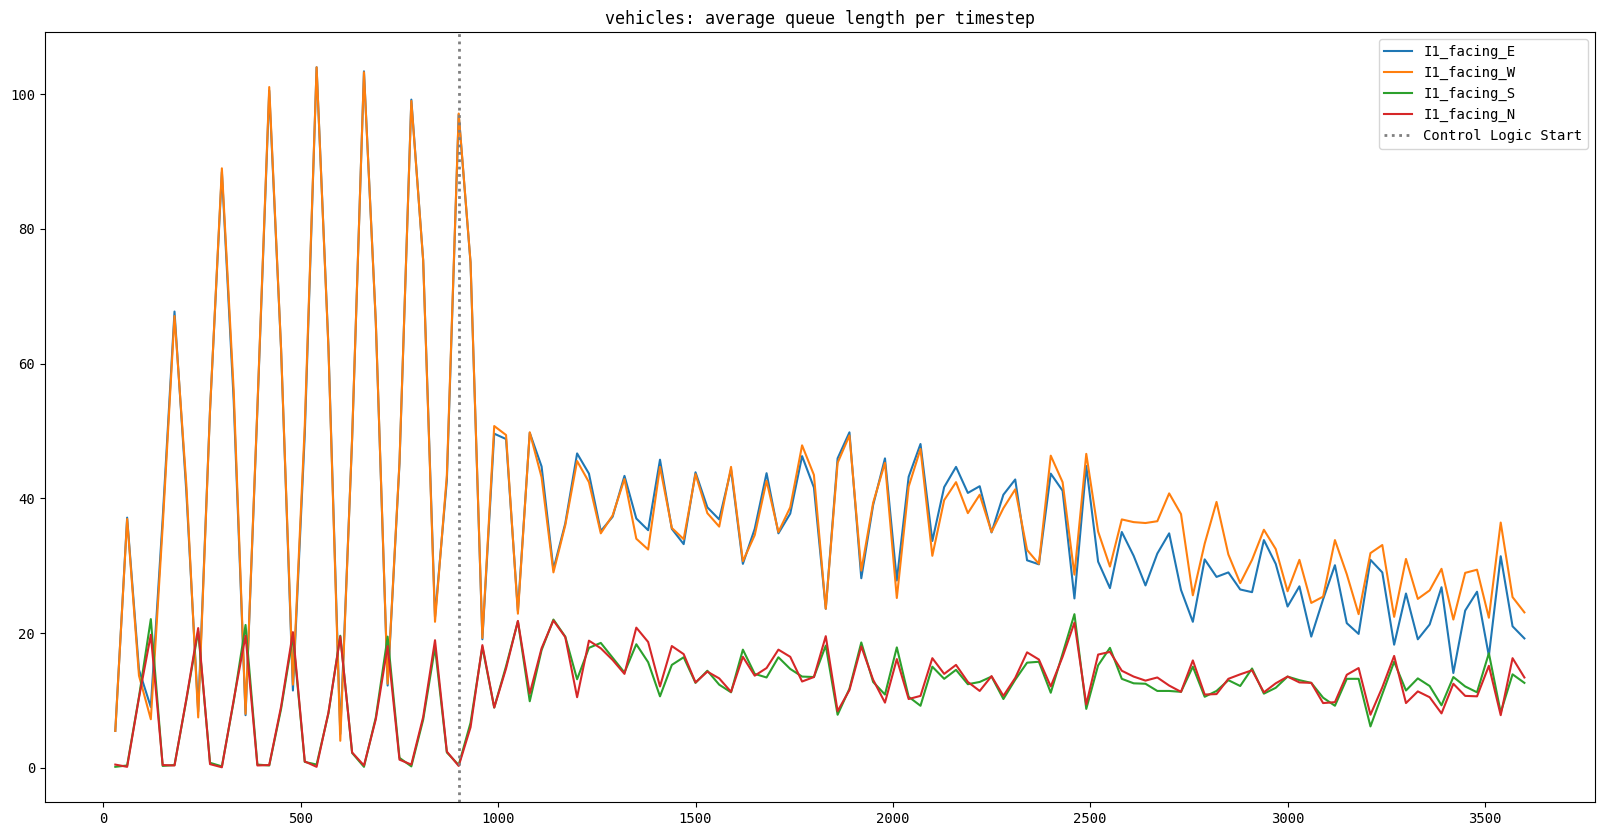

In [34]:
time = np.linspace(30,3600,num_time_steps)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
for link in links[8:12]:
    ax.plot(time,average_queue_per_link_per_ts_df[link], label = f"{link}")
plt.title('vehicles: average queue length per timestep')
ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

plt.legend()

In [14]:
def trendline(x,y):
    z = np.polyfit(x, y,1)
    p = np.poly1d(z)
    return p(x)

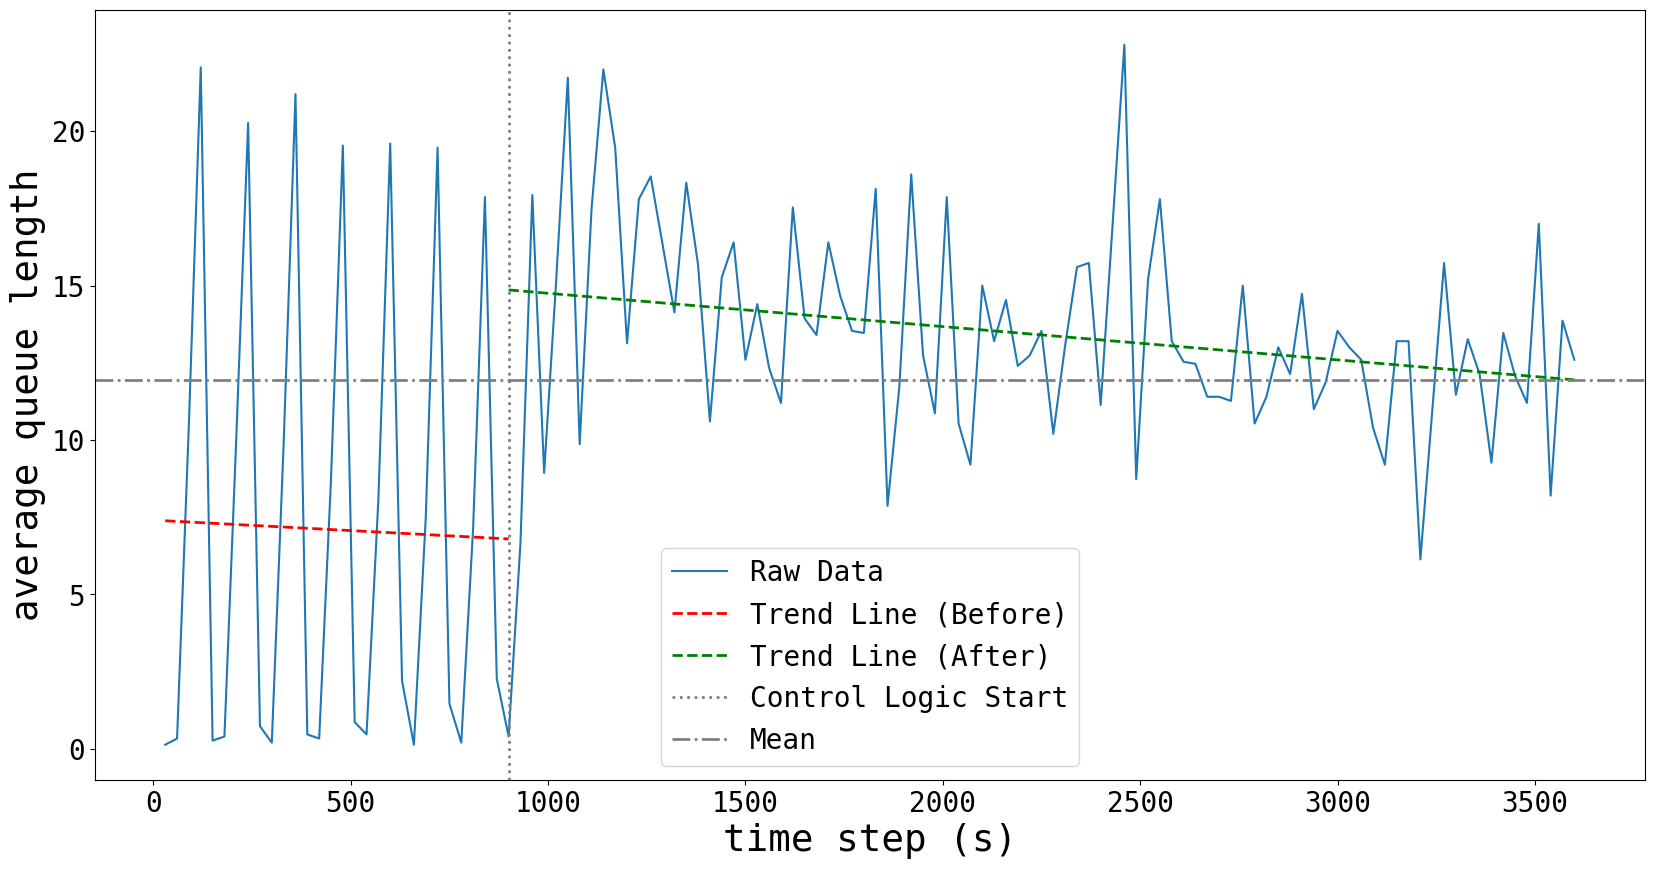

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

ax.plot(time,average_queue_per_link_per_ts_df["I1_facing_S"],label = "Raw Data")

window_size = 3
qq = average_queue_per_link_per_ts_df["I1_facing_S"].rolling(window=window_size).mean()
# ax.plot(time, qq, label="Rolling Average")

# Fit the trend line before
ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df["I1_facing_S"][0:30]),"r--", label = "Trend Line (Before)",linewidth = 2)

# after
ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df["I1_facing_S"][29:]),"g--", label = "Trend Line (After)",linewidth = 2)

ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.axhline(y=average_queue_per_link_df["I1_facing_S"][0], color='grey', linestyle="-.", linewidth=2, label='Mean')


ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)

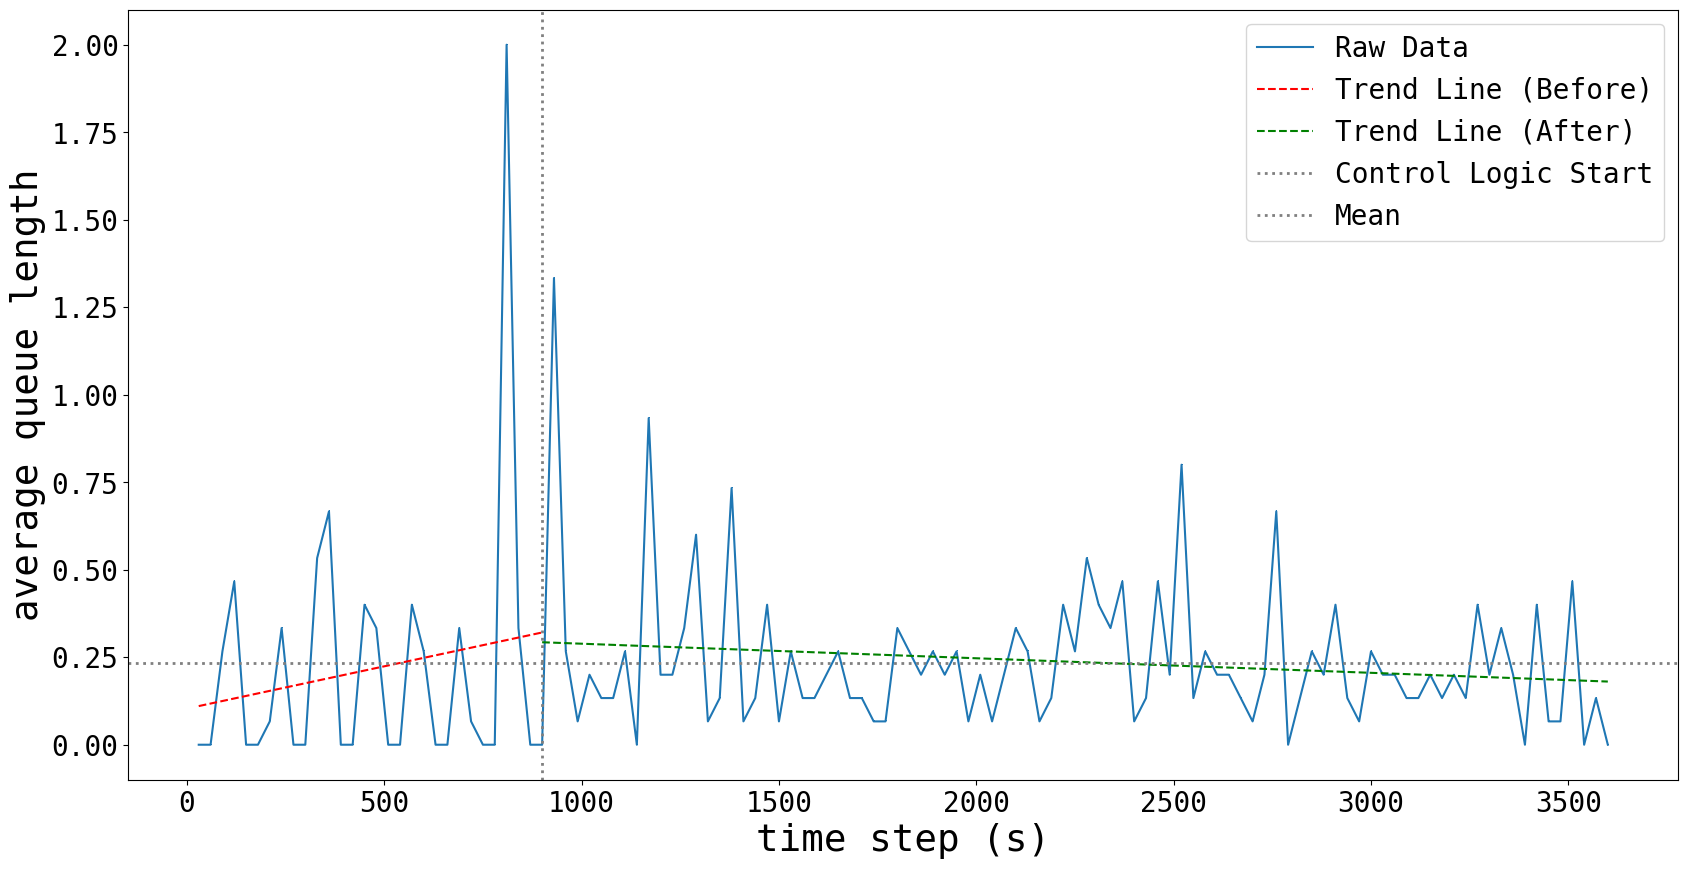

In [37]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

ax.plot(time,average_queue_per_link_per_ts_df["IN_to_PNE"],label = "Raw Data", marker = ",")

window_size = 3
qq = average_queue_per_link_per_ts_df["IN_to_PNE"].rolling(window=window_size).mean()
# ax.plot(time, qq, label="Rolling Average")

# Fit the trend line before
ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df["IN_to_PNE"][0:30]),"r--", label = "Trend Line (Before)")
# after
ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df["IN_to_PNE"][29:]),"g--", label = "Trend Line (After)")


#ax.plot(time,trendline(time, average_queue_per_link_per_ts_df["IN_to_PNE"])[0],"k--", label = "Trend Line (Total)")
ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')
ax.axhline(y=average_queue_per_link_df["IN_to_PNE"][0], color='grey', linestyle=":", linewidth=2, label='Mean')

# plt.ylim([0,1])

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)


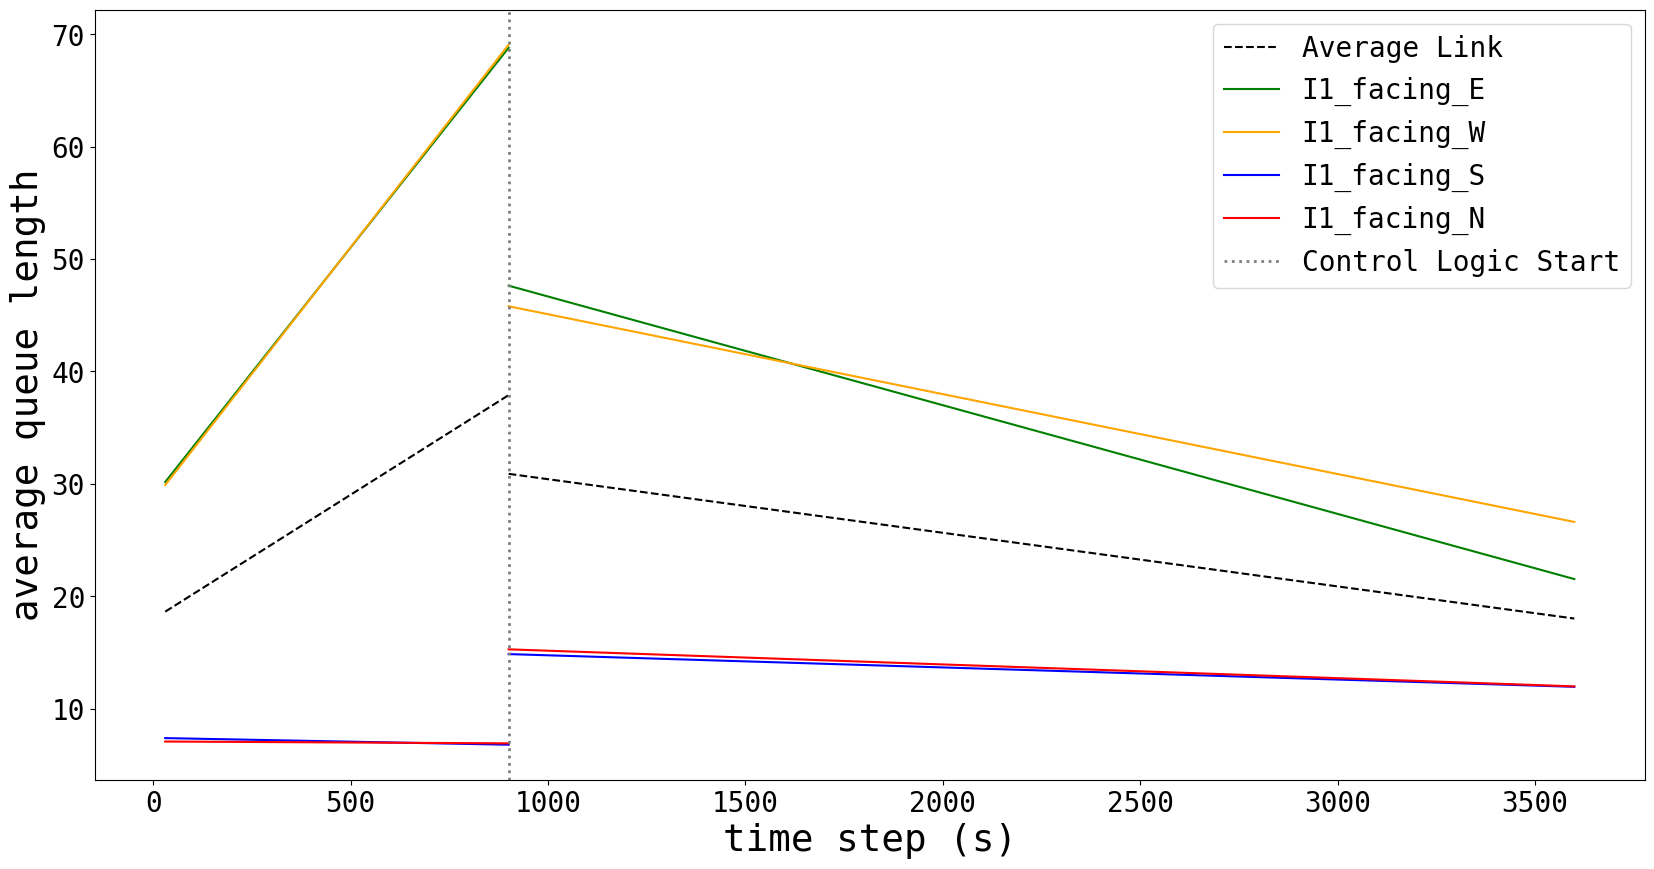

In [42]:
time = np.linspace(30,3600,num_time_steps)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

avg = average_queue_per_link_per_ts_df.iloc[:,8:12].sum(axis=1)/4
ax.plot(time[0:30],trendline(time[0:30],avg[0:30]), "k--",label = f"Average Link")
ax.plot(time[29:],trendline(time[29:],avg[29:]), "k--")

cc = {"I1_facing_N":"r","I1_facing_S":"b","I1_facing_E":"g","I1_facing_W":"orange"}

for link in links[8:12]:
    ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df[link][0:30]), color = cc[link], label = f"{link}")
    ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df[link][29:]), color = cc[link])


ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)

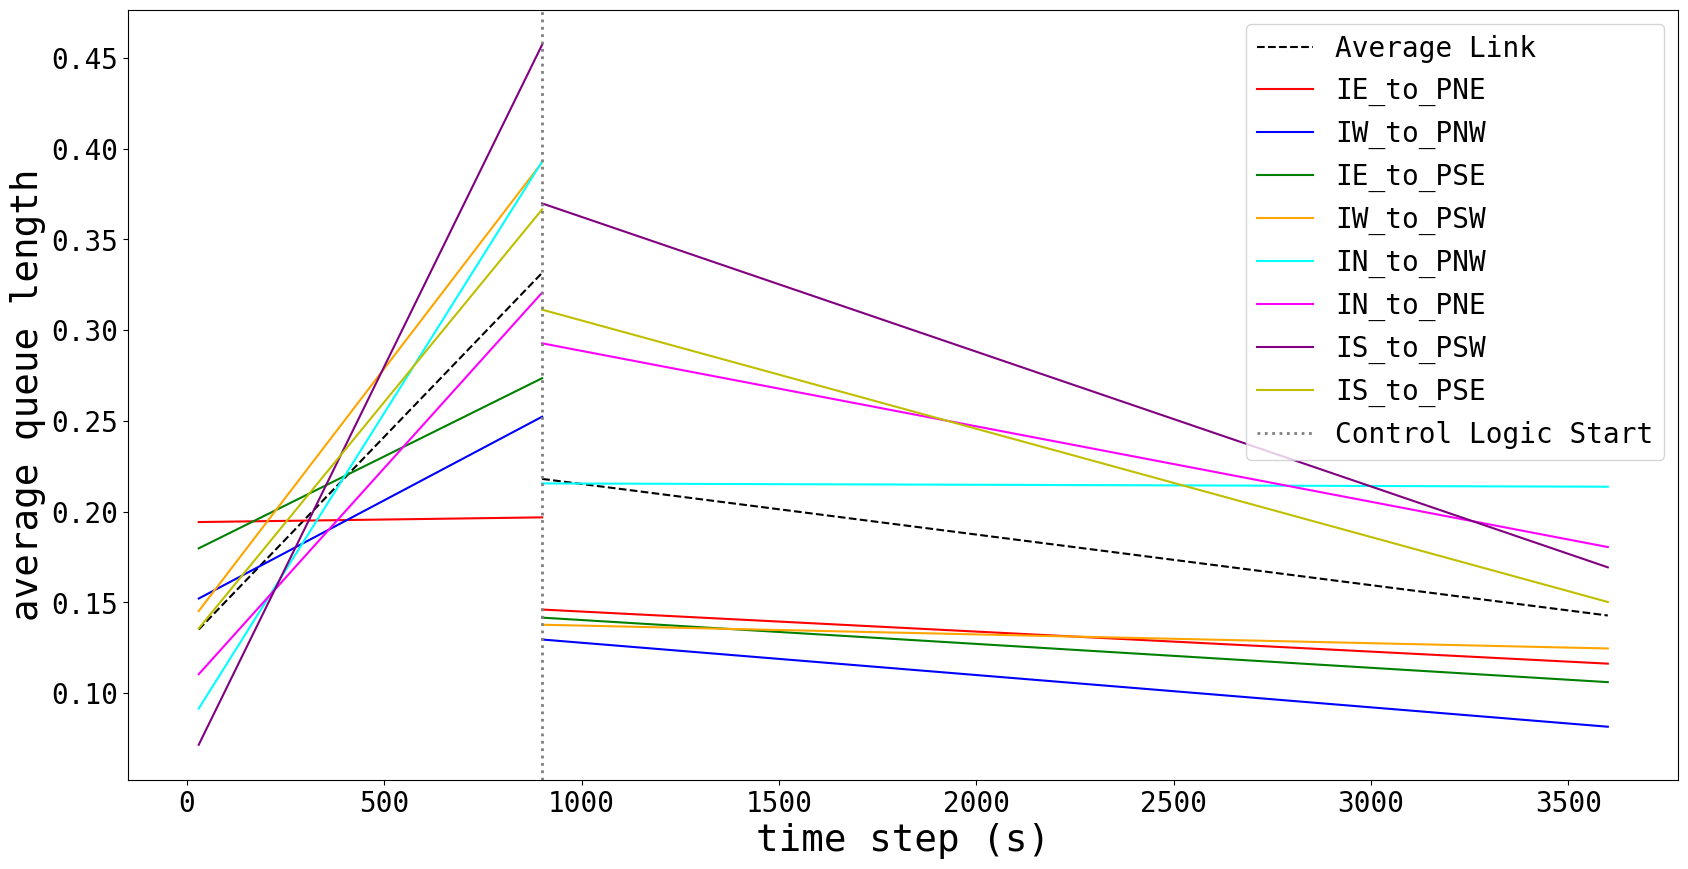

In [43]:
time = np.linspace(30,3600,num_time_steps)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

avg = average_queue_per_link_per_ts_df.iloc[:,0:8].sum(axis=1)/8
ax.plot(time[0:30],trendline(time[0:30],avg[0:30]), "k--",label = f"Average Link")
ax.plot(time[29:],trendline(time[29:],avg[29:]), "k--")

cc = {'IE_to_PNE':"r", 'IW_to_PNW':"b", 'IE_to_PSE':"g", 'IW_to_PSW':"orange", 'IN_to_PNW':"cyan",
      'IN_to_PNE':"magenta", 'IS_to_PSW':"purple", 'IS_to_PSE':"y"}

for link in links[0:8]:
    ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df[link][0:30]), color = cc[link], label = f"{link}")
    ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df[link][29:]), color = cc[link])


ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)

### Link Analysis

In [19]:
resultsdf["df_link_summary"][0]

,link,t,arrival_count,departure_count,actual_travel_time,instantanious_travel_time
0,W1I1,0,0,0,23.636364,23.636364
1,W1I1,1,0,0,23.636364,23.636364
2,W1I1,2,1,0,59.000000,23.636364
3,W1I1,3,2,0,58.000000,23.636364
4,W1I1,4,3,0,58.000000,23.636364
...,...,...,...,...,...,...
86395,PSEIE,3595,735,730,53.000000,714.285714
86396,PSEIE,3596,736,730,53.000000,714.285714
86397,PSEIE,3597,736,730,53.000000,42.857143
86398,PSEIE,3598,736,730,53.000000,42.857143


In [80]:
num_runs = len(resultsdf)
num_links_per_ts = len(resultsdf["df_link_summary"][0])

arrival_count_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
departure_count_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
actual_travel_time_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
instantanious_travel_time_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}

for run in range(num_runs):
    q_cl = resultsdf['df_link_summary'][run]
    for link in range(num_links_per_ts):
        arrival_count_per_link_per_ts[link] += q_cl['arrival_count'][link]/num_runs
        departure_count_per_link_per_ts[link] += q_cl['departure_count'][link]/num_runs
        actual_travel_time_per_link_per_ts[link] += q_cl['actual_travel_time'][link]/num_runs
        instantanious_travel_time_per_link_per_ts[link] += q_cl['instantanious_travel_time'][link]/num_runs

link_ = resultsdf["df_link_summary"][0]["link"].values
timestep = resultsdf["df_link_summary"][0]["t"].values

col_names = resultsdf["df_link_summary"][0].columns.values

data = [link_, timestep, arrival_count_per_link_per_ts,departure_count_per_link_per_ts,
        actual_travel_time_per_link_per_ts,instantanious_travel_time_per_link_per_ts]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = resultsdf["df_link_summary"][0].index.values

average_link_data_df = pd.DataFrame(data = data_dict, index = index) 

In [81]:
average_link_data_df = average_link_data_df[~average_link_data_df["link"].str.startswith("I")]

In [82]:
instant_travel_times = {"W1I1":23.636364, "E1I1":23.636364, "N1I1": 8.181818182, "S1I1": 8.181818182,
                        "PNEIE": 7.142857143,"PNEIN": 7.142857143,"PNWIN": 7.142857143,"PNWIW": 7.142857143,
                       "PSEIE": 7.142857143,"PSEIS": 7.142857143,"PSWIS": 7.142857143,"PSWIW": 7.142857143}
average_link_data_df['free_flow_time'] = average_link_data_df['link'].map(instant_travel_times)

In [83]:
average_link_data_df["travel_delay"] = average_link_data_df["actual_travel_time"]-average_link_data_df["free_flow_time"]

In [84]:
average_link_data_df

,link,t,arrival_count,departure_count,actual_travel_time,instantanious_travel_time,free_flow_time,travel_delay
0,W1I1,0,0.000000,0.000000,23.636364,23.636364,23.636364,-3.636364e-07
1,W1I1,1,0.000000,0.000000,23.636364,23.636364,23.636364,-3.636364e-07
2,W1I1,2,1.000000,0.000000,59.000000,23.636364,23.636364,3.536364e+01
3,W1I1,3,2.000000,0.000000,58.066667,23.636364,23.636364,3.443030e+01
4,W1I1,4,2.866667,0.000000,58.000000,23.636364,23.636364,3.436364e+01
...,...,...,...,...,...,...,...,...
86395,PSEIE,3595,768.666667,759.933333,11.266667,349.396825,7.142857,4.123810e+00
86396,PSEIE,3596,768.933333,760.000000,11.266667,417.968254,7.142857,4.123810e+00
86397,PSEIE,3597,769.000000,760.066667,11.266667,304.873460,7.142857,4.123810e+00
86398,PSEIE,3598,769.200000,760.133333,11.266667,321.301587,7.142857,4.123810e+00


In [85]:
average_link_data_df_before = average_link_data_df.iloc[np.where(average_link_data_df["t"]<=900)]
average_link_data_df_after = average_link_data_df.iloc[np.where(average_link_data_df["t"]>900)]

In [86]:
average_travel_time_before = np.sum(average_link_data_df_before["actual_travel_time"])/len(average_link_data_df_before)
average_travel_delay_before = np.sum(average_link_data_df_before["travel_delay"])/len(average_link_data_df_before)

average_travel_time_after = np.sum(average_link_data_df_after["actual_travel_time"])/len(average_link_data_df_after)
average_travel_delay_after = np.sum(average_link_data_df_after["travel_delay"])/len(average_link_data_df_after)

In [89]:
print("BEFORE: The average travel time is ", average_travel_time_before, "s and the average delay time is", average_travel_delay_before, "s")

BEFORE: The average travel time is  42.72679698523206 s and the average delay time is 32.66186185956539 s


In [90]:
print("AFTER: The average travel time is ", average_travel_time_after, "s and the average delay time is", average_travel_delay_after, "s")

AFTER: The average travel time is  36.216792227574 s and the average delay time is 26.151857101907332 s


### OD analysis

In [20]:
num_runs = len(resultsdf)
num_ods = len(resultsdf["df_od_summary"][0])

total_trips_per_od = {od: 0 for od in range(num_ods)}
total_completed_trips_per_od = {od: 0 for od in range(num_ods)}
average_travel_time_per_od = {od: 0 for od in range(num_ods)}
variance_travel_time_per_od = {od: 0 for od in range(num_ods)}
average_distance_traveled_per_veh_per_od = {od: 0 for od in range(num_ods)}
variance_distance_traveled_per_veh_per_od = {od: 0 for od in range(num_ods)}

for run in range(num_runs):
    q_od = resultsdf['df_od_summary'][run]
    for od in range(num_ods):
        total_trips_per_od[od] += q_od['total_trips'][od]/num_runs
        total_completed_trips_per_od[od] += q_od['completed_trips'][od]/num_runs
        average_travel_time_per_od[od] += (q_od['average_travel_time'][od])/num_runs
        variance_travel_time_per_od[od] += (q_od['stddiv_travel_time'][od])**2/num_runs
        average_distance_traveled_per_veh_per_od[od] += q_od['average_distance_traveled_per_veh'][od]/num_runs
        variance_distance_traveled_per_veh_per_od[od] += (q_od['stddiv_distance_traveled_per_veh'][od])**2/num_runs

origin = resultsdf["df_od_summary"][0]["orig"].values
destination = resultsdf["df_od_summary"][0]["dest"].values
free_travel_time = resultsdf["df_od_summary"][0]["free_travel_time"].values
shortest_distance = resultsdf["df_od_summary"][0]["shortest_distance"].values
col_names = resultsdf["df_od_summary"][0].columns.values

data = [origin,destination,total_trips_per_od,total_completed_trips_per_od,
       free_travel_time,average_travel_time_per_od,variance_travel_time_per_od,
       shortest_distance,average_distance_traveled_per_veh_per_od,variance_distance_traveled_per_veh_per_od]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = resultsdf["df_od_summary"][0].index.values

average_od_data_df = pd.DataFrame(data = data_dict, index = index) 
average_od_data_df["stddiv_travel_time"] = np.sqrt(average_od_data_df["stddiv_travel_time"])
average_od_data_df["stddiv_distance_traveled_per_veh"] = np.sqrt(average_od_data_df["stddiv_distance_traveled_per_veh"])

In [21]:
average_od_data_df # averaged across all 30 runs

,orig,dest,total_trips,completed_trips,free_travel_time,average_travel_time,stddiv_travel_time,shortest_distance,average_distance_traveled_per_veh,stddiv_distance_traveled_per_veh
0,W1,S1,1037.266667,1023.066667,31.818182,136.946400,59.718166,350.0,405.967806,20.844875
1,W1,E1,1249.200000,1219.200000,47.272727,140.109585,58.730209,520.0,439.903658,24.161341
2,W1,N1,702.333333,686.200000,31.818182,135.992294,55.522395,350.0,372.890546,21.003132
3,N1,W1,558.000000,549.533333,31.818182,51.916999,26.845767,350.0,236.282875,6.892044
4,N1,E1,345.533333,340.666667,31.818182,62.570705,28.465490,350.0,313.741524,26.928470
5,N1,S1,295.666667,290.733333,16.363636,64.087042,26.935356,180.0,325.563700,21.853616
6,E1,N1,1285.133333,1257.200000,31.818182,148.326237,61.243783,350.0,452.055058,24.962409
7,E1,W1,716.466667,705.866667,47.272727,142.775650,59.536403,520.0,362.232482,12.400761
8,E1,S1,1001.733333,978.333333,31.818182,146.109382,59.104713,350.0,405.532945,27.201582
9,S1,E1,589.266667,580.933333,31.818182,52.888685,28.508736,350.0,234.020296,21.797223


### Basic Metrics

In [22]:
num_runs = len(resultsdf)

total_trips = 0
completed_trips = 0
total_travel_time = 0
average_travel_time = 0
total_delay = 0
average_delay = 0

for run in range(num_runs):
    q_met = resultsdf['df_metrics'][run]
    total_trips += q_met['total_trips']/num_runs
    completed_trips += q_met['completed_trips']/num_runs
    total_travel_time += q_met['total_travel_time']/num_runs
    average_travel_time += q_met['average_travel_time']/num_runs
    total_delay += q_met['total_delay']/num_runs
    average_delay += q_met['average_delay']/num_runs
    
col_names = resultsdf["df_metrics"][0].columns.values

data = [total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = [0]

average_met_data_df = pd.DataFrame(data = data_dict, index = index) 

In [23]:
average_met_data_df

,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,12469.466667,12241.8,1.199104e+06,97.951156,829031.14632,67.720745


### Computation Time

In [44]:
runtimes;

avg_sim_runtime = np.mean(runtimes)
print("the average runtime for a simulation is",avg_sim_runtime, "s")

the average runtime for a simulation is 78.15846304893493 s


In [45]:
num_runs = len(resultsdf)

avg_mpc_runtime = 0

for run in range(num_runs):
    avg_mpc_runtime += np.mean(resultsdf["mpc_comp_times"][run])/num_runs

print("the average runtime for a simulation is",avg_mpc_runtime,"s")

the average runtime for a simulation is 0.46327339967091885 s


In [46]:
num_runs = len(resultsdf)
num_time_steps = len(resultsdf["mpc_comp_times"][0])

average_mpc_comp_time = {ts: 0 for ts in range(num_time_steps)}

for run in range(num_runs):
    q_mpc = resultsdf['mpc_comp_times'][run]
    for ts in range(num_time_steps):
        average_mpc_comp_time[ts] += q_mpc[ts]/num_runs
    
average_mpc_comp_time_df = pd.DataFrame.from_dict(average_mpc_comp_time, orient='index')

In [27]:
average_mpc_comp_time_df[0].mean()

np.float64(0.46327339967091885)

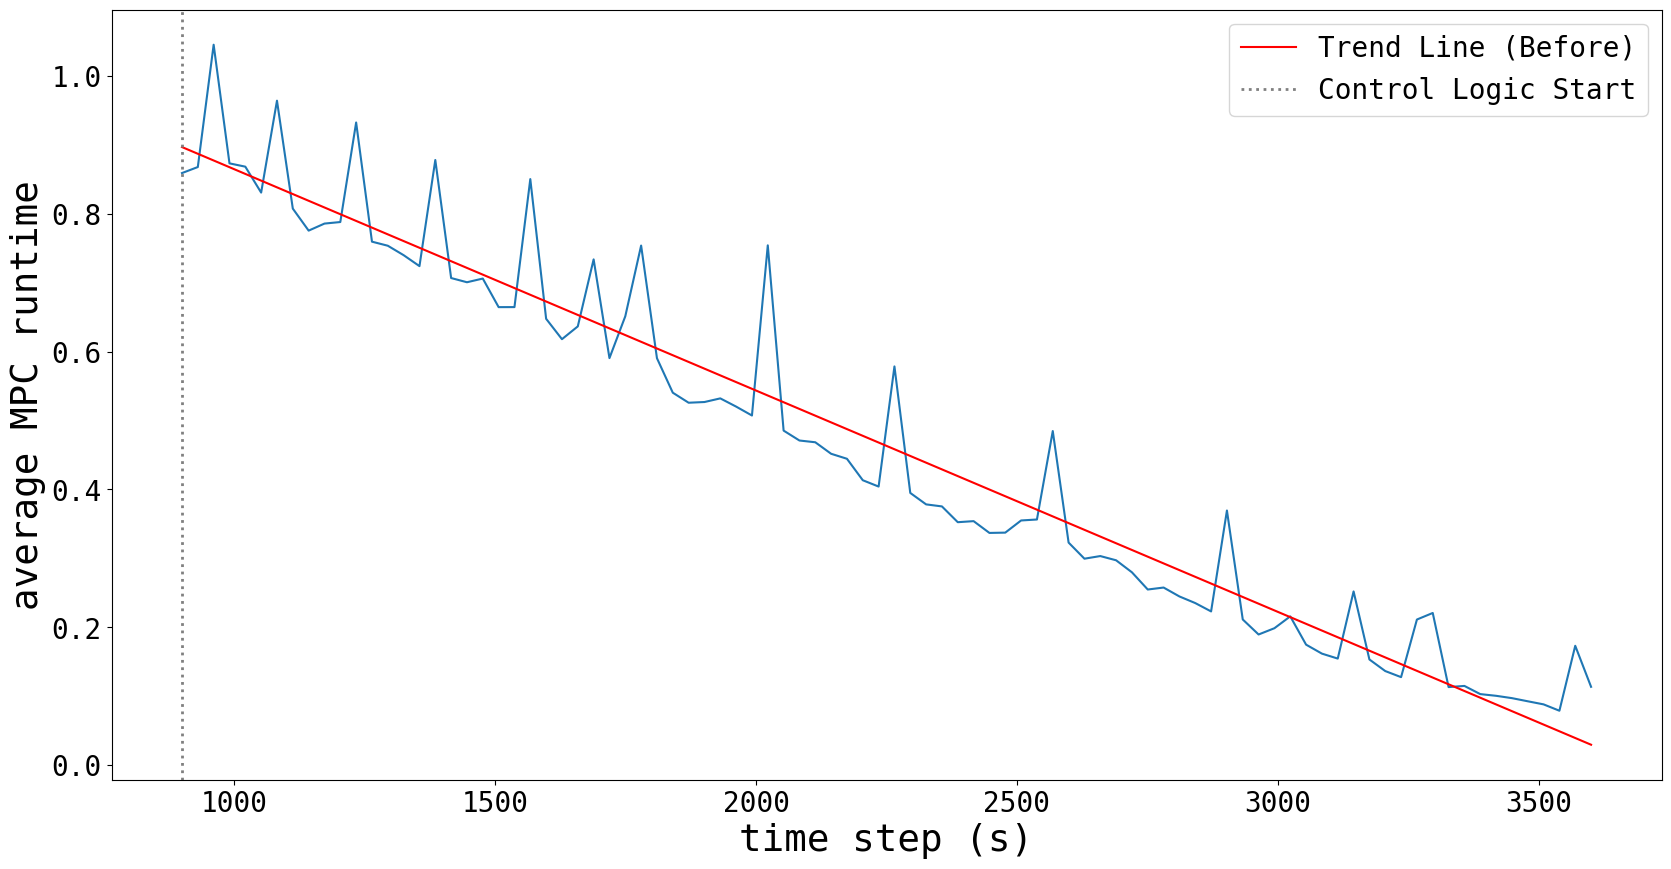

In [49]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

time = np.linspace(900,3600,len(average_mpc_comp_time_df))
ax.plot(time,average_mpc_comp_time_df)
ax.plot(time, trendline(time, average_mpc_comp_time_df[0] ),"r", label = "Trend Line (Before)")

ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average MPC runtime", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)